## Importing libraries

In [1]:
#Importing file paths
import os

#For managing dataframe
import pandas as pd
import numpy as np

#PyTorch
import torchaudio
import torch
import timm
from fastai.vision.models.unet import DynamicUnet
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms.functional import crop
from torch.utils.data import Dataset
from torch import nn


#Metrics
import seaborn as sb
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import ConfusionMatrix

from torch import optim

# Misc.
import PIL
import cv2
import warnings
import torchvision
from skimage.color import rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm_notebook

warnings.filterwarnings("ignore")

#Selecting device
device="cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device}")

Using cuda


## Checking sample images

In [2]:
im1= cv2.imread("../Dataset/subset_1/manga1/train/bw/01.jpg", cv2.IMREAD_GRAYSCALE)
im2=cv2.imread(("sample_image_02.png"),cv2.IMREAD_COLOR)

im1 = cv2.cvtColor(im1, cv2.COLOR_GRAY2RGB)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

print(im1.shape)
print(im2.shape)

(2359, 1665, 3)
(2448, 1665, 3)


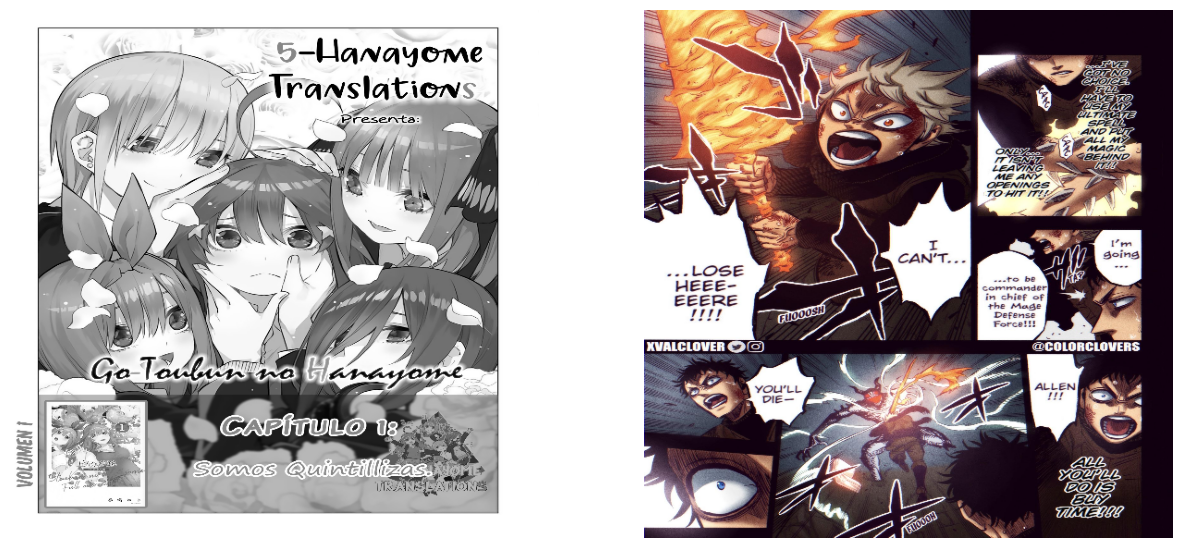

In [3]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(cv2.resize(im1,(572,572)))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(cv2.resize(im2,(572,572)))

## Dataset Creation

In [4]:
class dataset(Dataset):
    def __init__(self,bw_dir: str, color_dir: str):
        self.bw_images=[]
        self.color_images=[]
        
        for i in os.listdir(bw_dir):
            self.bw_images.append(bw_dir+"/"+i)

        for i in os.listdir(color_dir):
            self.color_images.append(color_dir+"/"+i)
            
        self.bw_images.sort()
        self.color_images.sort()
        
    def __len__(self):
        return len(self.bw_images)

    @staticmethod
    def preprocess(image: np.ndarray, flag: int) -> torch.Tensor:

        if(flag==0):
            dim=(572,572)
            
            #image=cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            image=torch.from_numpy(image).type(torch.float32)
            image=image.unsqueeze(dim=0)

        else:
            dim=(388,388)
            #image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image=torch.from_numpy(image).type(torch.float32)
        
        resizeIt=torchvision.transforms.Resize(dim)
        image=resizeIt(image)

        return image/255
        

    def __getitem__(self,index):
        #bw=self.preprocess(cv2.imread((self.bw_images[index])),0)
        #color=self.preprocess(cv2.imread((self.color_images[index])),1)
        self.transforms = torchvision.transforms.Compose([
                torchvision.transforms.Resize((256, 256),  PIL.Image.BICUBIC),
                torchvision.transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        img = PIL.Image.open(self.color_images[index]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = torchvision.transforms.ToTensor()(img_lab)
        
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1

        return {"L":L, "ab":ab}
        

In [5]:
BATCH_SIZE=8

train_ds=dataset("../Dataset/subset_2/bw/","../Dataset/subset_2/color/")
test_ds=dataset("../Dataset/subset_2/bw/","../Dataset/subset_2/test/")

train_loader=torch.utils.data.DataLoader(train_ds,BATCH_SIZE)
test_loader=torch.utils.data.DataLoader(test_ds,BATCH_SIZE)

#### Testing loaders

In [6]:
#plt.figure(figsize=(7,12))
i=1
data=next(iter(train_loader))
while(i<7):    
    rand_ind=torch.randint(0,BATCH_SIZE-1,size=(1,)).item()
    bw=data["L"][rand_ind].permute((1,2,0))
    #print(data["bw"][rand_ind].permute((1,2,0))
    color=data["ab"][rand_ind].permute((1,2,0))
    print(bw.shape,color.shape)
    i+=2
    '''
    plt.subplot(3,2,i)
    plt.axis(False)
    plt.imshow(bw)
    plt.subplot(3,2,i+1)
    plt.axis(False)
    plt.imshow(color)
    i+=2
    '''


torch.Size([256, 256, 1]) torch.Size([256, 256, 2])
torch.Size([256, 256, 1]) torch.Size([256, 256, 2])
torch.Size([256, 256, 1]) torch.Size([256, 256, 2])


## Model Formation

In [7]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)


PatchDiscriminator(3)

discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

In [8]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [9]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [10]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [11]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

### Test

In [12]:
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(test_loader)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm_notebook(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

In [13]:
# pip install fastai==2.4
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [14]:
resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18(), n_in=n_input, pretrained=True, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

In [18]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm_notebook(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item(), L.size(0))
            
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = torch.optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()        
pretrain_generator(net_G, train_loader, opt, criterion, 20)
torch.save(net_G.state_dict(), "res18-unet.pt")

  0%|          | 0/1125 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))
model = MainModel(net_G=net_G)
train_model(model, train_loader, 100)

model initialized with norm initialization


  0%|          | 0/1125 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [40]:
torch.save(net_G.state_dict(),"something.pt")

In [45]:
net_G=net_G.to("cpu")

In [69]:
data=next(iter(test_loader))

In [47]:
bw=data["L"]
color=data["ab"]

In [48]:
with torch.inference_mode():
    result=net_G(bw)

In [49]:

idk=lab_to_rgb(bw,result)

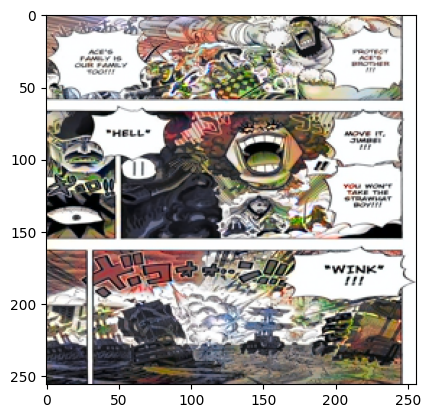

In [75]:
rand=torch.randint(8,(1,))
plt.imshow(idk[rand])

In [36]:
idk[rand].shape

(256, 256, 3)

In [62]:
d=next(iter(test_loader))

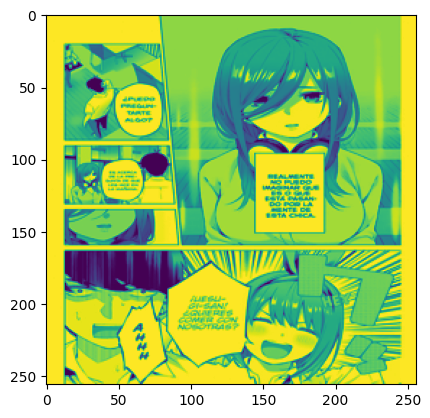

In [66]:
plt.imshow(d["L"][0].permute((1,2,0)))